In [8]:
import glob
import matplotlib
import matplotlib.pyplot as plt
import pickle
import lmfit
import numpy as np
import scipy.stats as ss
plt.style.use('seaborn-white')
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.formula.api import ols, rlm
import sys
sys.path.append('../')
from Linearity import Neuron

In [9]:
filename = '/media/sahil/NCBS_Shares_BGStim/patch_data/170303/c1/plots/c1.pkl'

In [16]:
#Colorscheme for squares
color_sqr = { index+1: color for index, color in enumerate(matplotlib.cm.viridis(np.linspace(0,1,9)))}

In [10]:
control_result2_rsquared_adj = []
control_result1_rsquared_adj = []
control_var_expected = []
gabazine_result2_rsquared_adj = []
gabazine_result1_rsquared_adj = []
gabazine_var_expected = []
tolerance = 5e-4

In [11]:
def linearModel(x, a=1):
    # Linear model
    return (a*x)

def DN_model(x,a=1):
    # Divisive normalization model
    #return x - a*(x**2)/(b+x)
    return x/(a*x+1)

In [12]:
lin_aic = []
dn_aic = []
lin_chi = []
dn_chi = []

control_observed = {}
control_observed_average = {}
gabazine_observed ={}
gabazine_observed_average = {}
control_expected = {}
control_expected_average = {}
gabazine_expected ={}
gabazine_expected_average = {}
feature = 0

neuron = Neuron.load(filename)
for expt in neuron.experiment:
    print ("Starting expt {}".format(expt))
    for numSquares in neuron.experiment[expt].keys(): 
        print ("Square {}".format(numSquares))
        if not numSquares == 1:
            nSquareData = neuron.experiment[expt][numSquares]
            if expt == "Control":
                coords_C = nSquareData.coordwise
                for coord in coords_C: 
                    if feature in coords_C[coord].feature:
                        control_observed_average.update({coord: coords_C[coord].average_feature[feature]})
                        control_expected_average.update({coord: coords_C[coord].expected_feature[feature]})
                        control_observed.update({coord: []})
                        control_expected.update({coord: []})
                        for trial in coords_C[coord].trials:
                            if feature in trial.feature:
                                control_observed[coord].append(trial.feature[feature])
                                control_expected[coord].append(coords_C[coord].expected_feature[feature])
            elif expt == "GABAzine":
                coords_I = nSquareData.coordwise
                for coord in coords_I: 
                    if feature in coords_I[coord].feature:
                        gabazine_observed.update({coord: []})
                        gabazine_expected.update({coord: []})
                        gabazine_observed_average.update({coord: coords_I[coord].average_feature[feature]})
                        gabazine_expected_average.update({coord: coords_I[coord].expected_feature[feature]})

                        for trial in coords_I[coord].trials:
                            if feature in trial.feature:
                                gabazine_observed[coord].append(trial.feature[feature])
                                gabazine_expected[coord].append(coords_I[coord].expected_feature[feature])
print ("Read {} into variables".format(filename))

Starting expt Control
Square 1
Square 2
Square 3
Square 5
Square 7
Square 9
Starting expt GABAzine
Square 1
Square 2
Square 3
Square 5
Square 7
Read /media/sahil/NCBS_Shares_BGStim/patch_data/170303/c1/plots/c1.pkl into variables


In [18]:
feature = 0 # Area under the curve
expected, observed, g_expected, g_observed = {}, {}, {}, {}
for exp in neuron:
    for sqr in exp:
        ## Control case
        if(exp[sqr].type == "Control"):
            if sqr > 1:
                expected[sqr] = []
                observed[sqr] = []
                for coord in exp[sqr].coordwise:
                    for trial in exp[sqr].coordwise[coord].trials:
                        if all([value == 0 for value in trial.flags.values()]):
                            expected[sqr].append(exp[sqr].coordwise[coord].expected_feature[feature])
                            observed[sqr].append(trial.feature[feature])

[[Model]]
    Model(linearModel)
[[Fit Statistics]]
    # function evals   = 6
    # data points      = 334
    # variables        = 1
    chi-square         = 787.840
    reduced chi-square = 2.366
    Akaike info crit   = 288.623
    Bayesian info crit = 292.434
[[Variables]]
    a:   0.40100283 +/- 0.008347 (2.08%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)

[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 21
    # data points      = 334
    # variables        = 1
    chi-square         = 357.317
    reduced chi-square = 1.073
    Akaike info crit   = 24.539
    Bayesian info crit = 28.350
[[Variables]]
    a:   0.12251295 +/- 0.002948 (2.41%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)



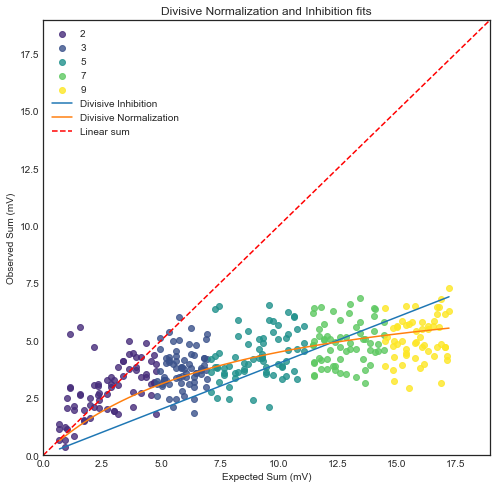

In [19]:
max_exp, max_g_exp = 0.,0.
f, ax = plt.subplots()
color=iter(matplotlib.cm.viridis(np.linspace(0,1,len(observed))))
squareVal = []
list_control_expected = []
list_control_observed = []

for sqr in sorted(observed):
    squareVal.append(ax.scatter(expected[sqr], observed[sqr], label=str(sqr), c=color_sqr[sqr], alpha=0.8))
    max_exp = max(max_exp, max(expected[sqr]))
    list_control_expected += expected[sqr]
    list_control_observed += observed[sqr]
    
X = np.array(list_control_expected)
y = np.array(list_control_observed)
idx   = np.argsort(X)
X = X[idx]
y = y[idx]

linear_Model = lmfit.Model(linearModel)
DN_Model = lmfit.Model(DN_model)

lin_pars = linear_Model.make_params()
lin_result = linear_Model.fit(y, lin_pars, x=X)
lin_aic.append(lin_result.aic)
lin_chi.append(lin_result.redchi)

DN_pars = DN_Model.make_params()
DN_result = DN_Model.fit(y, DN_pars, x=X)
dn_aic.append(DN_result.aic)
dn_chi.append(DN_result.redchi)

print (lin_result.fit_report())
print (DN_result.fit_report())

ax.set_xlim(xmin=0.)
ax.set_ylim(ymin=0.)
ax.set_xlabel("Expected")
ax.set_ylabel("Observed")
ax.set_title("Divisive Normalization and Inhibition fits")
div_inh = ax.plot(X, lin_result.best_fit, '-')
div_norm = ax.plot(X, DN_result.best_fit, '-')


max_exp *=1.1
max_g_exp *=1.1
ax.set_xlim(0,max_exp)
ax.set_ylim(0,max_exp)
ax.set_xlabel("Expected Sum (mV)")
ax.set_ylabel("Observed Sum (mV)")
linear = ax.plot((0,max_exp), (0,max_exp), 'r--')

legends = squareVal + div_inh + div_norm + linear
labels = sorted(observed.keys()) + ["Divisive Inhibition", "Divisive Normalization", "Linear sum"]

f.set_figwidth(8)
f.set_figheight(8)
ax.legend(legends, labels)
plt.show()